# 1. Using the all-in-one parser `src.reaction_string_parser`

The code uses set to parse species in given string, so if `sort_species_by` is not specified, the default sequence of species arbitrary (although the corresponding relationship between species names, reactant matrix, and product matrix will still be conserved). You may specify rate constant name in reaction string; the code will automatically assign a rate constant name to your reaction if not provided.

In [1]:
from src.reaction_string_parser import *

# initialize an instance of reaction_string_parser
rsp = ReactionStringParser()

# sorting while parsing
# Example usage:
reaction_strings = ["E + S -> ES", "ES -> E + P"]
species_names, rate_constant_names, reactant_matrix, product_matrix =\
        rsp.parse_reaction_strings(reaction_strings, sort_species_by="increasing")

print("Species Names:")
print(species_names)
print("Reactant Stoichiometry Matrix:")
print(reactant_matrix)
print("Product Stoichiometry Matrix:")
print(product_matrix)
print("Rate Constant Values: Placeholder. for future use, I think rate constant not from string is better for now?")
print("Rate Constant Names:")
print(rate_constant_names)

Species Names:
['E' 'ES' 'P' 'S']
Reactant Stoichiometry Matrix:
[[1 0 0 1]
 [0 1 0 0]]
Product Stoichiometry Matrix:
[[0 1 0 0]
 [1 0 1 0]]
Rate Constant Values: Placeholder. for future use, I think rate constant not from string is better for now?
Rate Constant Names:
['k0', 'k1']


## 1.1. Decimal / fraction

To enable decimal / fraction support for `src.reaction_string_parser`, add a flag `dtype = float` when using the parser as follows.

In [2]:
# Example usage:
# Remember to set dtype to float to enable decimal / fraction support!
reaction_strings = ["0.6A + 1/4 B -> C, kon", "C -> 0.6 A + 1/4 B, koff"]
species_names, rate_constant_names, reactant_matrix, product_matrix =\
        rsp.parse_reaction_strings(reaction_strings, dtype = float)

print("Species Names:")
print(species_names)
print("Reactant Stoichiometry Matrix:")
print(reactant_matrix)
print("Product Stoichiometry Matrix:")
print(product_matrix)
print("Rate Constant Names:")
print(rate_constant_names)

Species Names:
['A' 'B' 'C']
Reactant Stoichiometry Matrix:
[[0.6  0.25 0.  ]
 [0.   0.   1.  ]]
Product Stoichiometry Matrix:
[[0.   0.   1.  ]
 [0.6  0.25 0.  ]]
Rate Constant Names:
['kon', 'koff']


## 1.2. Regular expression

The string parser uses regex to maximize syntax compatibility in parser strings. Also, you can customize the regex  when you initialize the instance of `ReactionStringParser`. An example is as follows.

In [3]:
# initialize a customized instance of reaction_string_parser
rsp_customized = ReactionStringParser(rightward_reaction_symbol = r">+")

# Example usage:
# Remember to set dtype to float to enable decimal / fraction support!
reaction_strings = ["A + B >>>>>> C"]
species_names, rate_constant_names, reactant_matrix, product_matrix =\
        rsp_customized.parse_reaction_strings(reaction_strings, dtype = float)

print("Species Names:")
print(species_names)
print("Reactant Stoichiometry Matrix:")
print(reactant_matrix)
print("Product Stoichiometry Matrix:")
print(product_matrix)
print("Rate Constant Names:")
print(rate_constant_names)

Species Names:
['A' 'B' 'C']
Reactant Stoichiometry Matrix:
[[1. 1. 0.]]
Product Stoichiometry Matrix:
[[0. 0. 1.]]
Rate Constant Names:
['k0']


# 2. Solver for IVP

You can use the integrated IVP solver (using scipy ivp solver and matplotlib plotting) in reaction ODE solver to easily generate ODE solution for your system.

Species Names:
['E' 'ES' 'P' 'S']
Rate Constant Names:
['k2', 'k3']


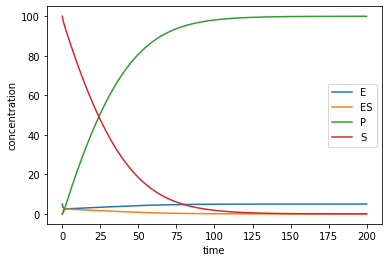

In [4]:
from src.reaction_ode_solver import *

# Example usage:
# Generate reaction system
reaction_strings = ["E + S -> ES", "ES -> E + P"]
species_names, rate_constant_names, reactant_matrix, product_matrix =\
        rsp.parse_reaction_strings(reaction_strings, sort_species_by="increasing")

print("Species Names:")
print(species_names)
print("Rate Constant Names:")
print(rate_constant_names)

# Rate constant assuming already non-dimensionalized
rate_constants = [0.01, 1.0]

# Define time span and initial concentration, assuming already non-dimensionalized
t_span = [0.0, 200.0]
y_init = [5.0, 0.0, 0.0, 100.0]

solve_reaction_ode(dydt, t_span, y_init, reactant_matrix = reactant_matrix,
                                             product_matrix = product_matrix,
                                             k = rate_constants,
                                             species_names = species_names)

## 2.1. Generate `dydt`

If you wish to use an optimized ODE solver and just want the `dydt` function, `src.reaction_ode_solver` gives a standardized function to generate `dydt` function based on reactant_matrix, product_matrix, and rate constants. Note, `functools.partial` might be useful since most IVP solvers only takes in `dydt(t, y)`.

In [5]:
from functools import partial

# note the dydt function is in src.reaction_ode_solver so another naming is needed for disambiguation
dydt_ = partial(dydt, reactant_matrix = reactant_matrix,
                      product_matrix = product_matrix,
                      k = rate_constants)

# 3. Gillespie

The Gillespie algorithm is a stochastic simulation algorithm used to model the time evolution of chemical reaction systems. It is particularly useful for systems with low reactant counts and when stochastic effects play a significant role. The `gillespie_simulation` function provided in `src.reaction_gillespie` module (src/reaction_gillespie.py) allows you to perform Gillespie simulations for a given chemical reaction system. `convert_to_microscopic_rate_constants` enables automatic conversion between microscopic and macroscopic rate constant (assuming concentration in M and volume in L).

Note that `y` now refers to copy number instead of concentration

In [6]:
from src.reaction_gillespie import *

# Example usage:
# Generate reaction system
reaction_strings = ["E + S -> ES", "ES -> E + P"]
species_names, rate_constant_names, reactant_matrix, product_matrix =\
        rsp.parse_reaction_strings(reaction_strings, sort_species_by="increasing")

print("Species Names:")
print(species_names)
print("Rate Constant Names:")
print(rate_constant_names)

# Convert rate constant to microscopic assuming already non-dimensionalized
volume =1e-15 # Litre
macroscopic_rate_constants = [0.1e9, 1000.0]
microscopic_rate_constants = \
    convert_to_microscopic_rate_constants(macroscopic_rate_constants, reactant_matrix, volume)

# Define time and initial concentration, assuming already non-dimensionalized
tot_time = 200
y_init = [1, 0, 0, 100]

# Run gillespie
y_record, t_record = gillespie_simulation(tot_time, y_init, reactant_matrix,
                                          product_matrix, microscopic_rate_constants)

# plotting
import matplotlib.pyplot as plt
plt.figure(figsize = [16, 8])
plt.plot(t_record, y_record)
plt.legend(species_names)

Species Names:
['E' 'ES' 'P' 'S']
Rate Constant Names:
['k4', 'k5']


/Users/yueying/Workspace/Reaction_ode/Reaction_ivp_solver/src/reaction_gillespie.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  tau = - (1.0 / r_tot) * np.log(np.random.rand())
/Users/yueying/Workspace/Reaction_ode/Reaction_ivp_solver/src/reaction_gillespie.py:198: RuntimeWarning: invalid value encountered in true_divide
  reaction_index_chose = np.random.choice(index, p=propensities / r_tot)


ValueError: probabilities contain NaN